In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from datetime import datetime
from pprint import pprint

%matplotlib inline

# Credit Risk Score Prediction on Aave Protocol v2

*Disclaimer: this effort is made with limited knowledge on aave governance, and hence some assumptions are addressed as necessary.*

## 1. Exploratory and Analysis

The v2 protocol is chosen as it contains more recent data. On the other hand, the v1 protocol shows deposit history for the year 2020 for some reason. Based on the requirement, we query 100 addresses of `user` data together with their respective `unclaimedRewards`, `lifetimeRewards`, `incentivizedActions`, last 100 addresses of the `depositHistory`, `borrowHistory`, `repayHistory`, and `redeemUnderlyingHistory`.

In [2]:
# Source: https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03
# https://github.com/finlytics-hub/credit_risk_model
def run_query(query):

    # endpoint for making the request
    # https://api.thegraph.com/subgraphs/name/aave/protocol
    # https://api.thegraph.com/subgraphs/name/aave/protocol-multy-raw
    request = requests.post('https://api.thegraph.com/subgraphs/name/aave/protocol-v2'
                            '',
                            json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, query))

In [3]:
users_query = """
{
  users(where: {
    id_not_in: ["0x0000000000000000000000000000000000000001",
                "0x000000000000000000000000000000000000dead"]
  }){
    id
    unclaimedRewards
    lifetimeRewards
    depositHistory(orderBy: timestamp, orderDirection: desc,) {
      id
      amount
      timestamp
      reserve {
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    borrowHistory(orderBy: timestamp, orderDirection: desc) {
      id
      amount
      timestamp
      reserve {
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
      borrowRate
      borrowRateMode
      stableTokenDebt
      variableTokenDebt
    }
    repayHistory(orderBy: timestamp, orderDirection: desc){
      id
      amount
      timestamp
      reserve{
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    redeemUnderlyingHistory(orderBy: timestamp, orderDirection: desc){
      id
      amount
      timestamp
      reserve{
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    incentivizedActions{
      id
      amount
    }
  }
}
"""


In [4]:
users_result = run_query(users_query)
#pprint(user_result)
#users_result['data']['users']

In [5]:
def extract_deposit_history(user_id, deposit=None):
    """
    Extract deposit history from a given user
    """
        
    deposit_dict = dict(
        user_id = user_id,
        deposit_reserve_name = '',
        deposit_reserve_symbol = '',
        deposit_reserve_priceInEth = 0,
        deposit_reserve_liquidityRate = 0,
        deposit_reserve_variableBorrowRate = 0,
        deposit_reserve_stableBorrowRate = 0,
        deposit_amount = 0,
        deposit_timestamp_unix = None,
        deposit_timestamp = None
    )
    
    if deposit:
        deposit_dict['deposit_reserve_name'] = deposit['reserve']['name']
        deposit_dict['deposit_reserve_symbol'] = deposit['reserve']['symbol']
        deposit_dict['deposit_reserve_priceInEth'] = int(deposit['reserve']['price']['priceInEth'])
        deposit_dict['deposit_reserve_liquidityRate'] = int(deposit['reserve']['liquidityRate'])
        deposit_dict['deposit_reserve_variableBorrowRate'] = int(deposit['reserve']['variableBorrowRate'])
        deposit_dict['deposit_reserve_stableBorrowRate'] = int(deposit['reserve']['stableBorrowRate'])
        deposit_dict['deposit_amount'] = int(deposit['amount'])
        deposit_dict['deposit_timestamp_unix'] = deposit['timestamp']
        deposit_dict['deposit_timestamp'] = pd.to_datetime(deposit['timestamp'], 
                                                           unit='s', errors='ignore')
        
    return deposit_dict

def extract_borrow_history(user_id, borrow=None):
    """
    Extract borrow history from a given user
    """
    borrow_dict = dict(
        user_id = user_id,
        borrow_reserve_name = '',
        borrow_reserve_symbol = '',
        borrow_reserve_priceInEth = 0,
        borrow_reserve_liquidityRate = 0,
        borrow_reserve_variableBorrowRate = 0,
        borrow_reserve_stableBorrowRate = 0,
        borrow_amount = 0,
        borrow_timestamp_unix = None,
        borrow_timestamp = None,
        borrow_rate = 0,
        borrow_rate_mode = '',
        borrow_stableTokenDebt = 0,
        borrow_variableTokenDebt = 0
        #borrow_accrued_interest = 0
    )
    
    if borrow:
        borrow_dict['borrow_reserve_name'] = borrow['reserve']['name']
        borrow_dict['borrow_reserve_symbol'] = borrow['reserve']['symbol']
        borrow_dict['borrow_reserve_priceInEth'] = int(borrow['reserve']['price']['priceInEth'])
        borrow_dict['borrow_reserve_liquidityRate'] = int(borrow['reserve']['liquidityRate'])
        borrow_dict['borrow_reserve_variableBorrowRate'] = int(borrow['reserve']['variableBorrowRate'])
        borrow_dict['borrow_reserve_stableBorrowRate'] = int(borrow['reserve']['stableBorrowRate'])
        borrow_dict['borrow_amount'] = int(borrow['amount'])
        borrow_dict['borrow_timestamp_unix'] = borrow['timestamp']
        borrow_dict['borrow_timestamp'] = pd.to_datetime(borrow['timestamp'],
                                                         unit='s', errors='ignore')
        borrow_dict['borrow_rate'] = int(borrow['borrowRate'])
        borrow_dict['borrow_rate_mode'] = borrow['borrowRateMode']
        borrow_dict['borrow_stableTokenDebt'] = borrow['stableTokenDebt']
        borrow_dict['borrow_variableTokenDebt'] = borrow['variableTokenDebt']
        #borrow_dict['borrow_accrued_interest'] = int(borrow['accruedBorrowInterest'])
    
    return borrow_dict

def extract_repay_history(user_id, repay=None):
    """
    Extract repay history from a given user
    """
    repay_dict = dict(
        user_id = user_id,
        repay_reserve_name = '',
        repay_reserve_symbol = '',
        repay_reserve_priceInEth = 0,
        repay_reserve_liquidityRate = 0,
        repay_reserve_variableBorrowRate = 0,
        repay_reserve_stableBorrowRate = 0,
        repay_amount = 0,
        repay_timestamp_unix = None,
        repay_timestamp = None
    )
    
    if repay:
        repay_dict['repay_reserve_name'] = repay['reserve']['name']
        repay_dict['repay_reserve_symbol'] = repay['reserve']['symbol']
        repay_dict['repay_reserve_priceInEth'] = int(repay['reserve']['price']['priceInEth'])
        repay_dict['repay_reserve_liquidityRate'] = int(repay['reserve']['liquidityRate'])
        repay_dict['repay_reserve_variableBorrowRate'] = int(repay['reserve']['variableBorrowRate'])
        repay_dict['repay_reserve_stableBorrowRate'] = int(repay['reserve']['stableBorrowRate'])
        repay_dict['repay_amount'] = int(repay['amount'])
        repay_dict['repay_timestamp_unix'] = repay['timestamp']
        repay_dict['repay_timestamp'] = pd.to_datetime(repay['timestamp'],
                                                       unit='s', errors='ignore')

    return repay_dict


def extract_redeemUnderlying_history(user_id, redeem=None):
    
    redeem_dict = dict(
        user_id = user_id,
        redeem_reserve_name = '',
        redeem_reserve_symbol = '',
        redeem_reserve_priceInEth = 0,
        redeem_reserve_liquidityRate = 0,
        redeem_reserve_variableBorrowRate = 0,
        redeem_reserve_stableBorrowRate = 0,
        redeem_amount = 0,
        redeem_timestamp_unix = None,
        redeem_timestamp = None
    )
    
    if redeem:
        redeem_dict['redeem_reserve_name'] = redeem['reserve']['name']
        redeem_dict['redeem_reserve_symbol'] = redeem['reserve']['symbol']
        redeem_dict['redeem_reserve_priceInEth'] = int(redeem['reserve']['price']['priceInEth'])
        redeem_dict['redeem_reserve_liquidityRate'] = int(redeem['reserve']['liquidityRate'])
        redeem_dict['redeem_reserve_variableBorrowRate'] = int(redeem['reserve']['variableBorrowRate'])
        redeem_dict['redeem_reserve_stableBorrowRate'] = int(redeem['reserve']['stableBorrowRate'])
        redeem_dict['redeem_amount'] = int(redeem['amount'])
        redeem_dict['redeem_timestamp_unix'] = int(redeem['timestamp'])
        redeem_dict['redeem_timestamp'] = pd.to_datetime(redeem['timestamp'],
                                                         unit='s', errors='ignore')

    return redeem_dict
    



In [6]:
users, deposits, borrows, repays, redeems = [], [], [], [], []
for user in users_result['data']['users']:
    #print(user, '\n')
    
    user_id = user['id']
        
    users.append(dict(
        user_id = user_id,
        user_unclaimedRewards = int(user['unclaimedRewards']),
        user_lifetimeRewards = int(user['lifetimeRewards']),
        user_incentivizedActions = int(user['incentivizedActions'][0]['amount']) \
            if user['incentivizedActions'] else 0
    ))
    
    # extract depositHistory
    if user['depositHistory']:
        for deposit in user['depositHistory']:
            deposit_dict = extract_deposit_history(user_id, deposit)
            deposits.append(deposit_dict)
    else:
        deposit_dict = extract_deposit_history(user_id)
        deposits.append(deposit_dict)
    
    # extract borrowHistory
    if user['borrowHistory']:
        for borrow in user['borrowHistory']:
            borrow_dict = extract_borrow_history(user_id, borrow)
            borrows.append(borrow_dict)
    else:
        borrow_dict = extract_borrow_history(user_id)
        borrows.append(borrow_dict)
   
    # extract repayHistory
    if user['repayHistory']:
        for repay in  user['repayHistory']:
            repay_dict = extract_repay_history(user_id, repay)
            repays.append(repay_dict)
    else:
        repay_dict = extract_repay_history(user_id)
        repays.append(repay_dict)
        
    # extract redeemUnderlyingHistory
    if user['redeemUnderlyingHistory']:
        for redeem in user['redeemUnderlyingHistory']:
            redeem_dict = extract_redeemUnderlying_history(user_id, redeem)
            redeems.append(redeem_dict)
    else:
        redeem_dict = extract_redeemUnderlying_history(user_id)
        redeems.append(redeem_dict)
            

In [7]:
users_df = pd.DataFrame(users)
users_df.head()

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,46,46,4
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,7217726631361778,7217726631361778,2964438606538810
2,0x00000000005dbcb0d0513fcda746382fe8a53468,0,0,0
3,0x00000000009a41862f3b2b0c688b7c0d1940511e,0,0,0
4,0x0000000000d41c96294ccdac8612bdfe29c641af,0,0,0


### 1.1. No. of user with no rewards / incentivized actions and deposits / borrows

In [8]:

print(f'no unclaimed rewards: {len(users_df[users_df.user_unclaimedRewards == 0])}')
print(f'no lifetime rewards: {len(users_df[users_df.user_lifetimeRewards == 0])}')
print(f'no incentivized actions: {len(users_df[users_df.user_incentivizedActions == 0])}')


no unclaimed rewards: 69
no lifetime rewards: 63
no incentivized actions: 63


Out of 100 users, there are 6 users with lifetime rewards and incentivized actions but do not have unclaimed rewards. And there are 2 users that have not claimed all the lifetime rewards.

In [9]:
users_df[users_df.user_unclaimedRewards != users_df.user_lifetimeRewards]

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions
40,0x00137878c7c179cad13505c18c86fd84623f04c7,0,1643451823147600233,514903473
42,0x0013eb108d5168bf2285f0f54172394f7c17d17d,0,7243024470815893431,7243024470815893431
43,0x0014a4f88a92d3924a3f553dc51c290ce06ae125,45197643421884619,13346803142920585986,3866509416886132830
58,0x002ad2406d6d05e0c58e39af6eb506f762e9f7bb,0,2954459110650692796,378448660935842508
64,0x0032311e56bc34efde20b408bb99d986eea1863a,88526724098484314,477083392433139171,13889109675855785
80,0x00405dc6b34d782df3feb0f0ec308fc27d4bd6bb,0,3802339088532774779,705246126826882783
90,0x004c350cd1ab72ea28cd6c47935b5bb31f64a928,0,1305510934083713815,694339479806045139
92,0x004f137c71b3003c7915bd6aa3a4f57e334a738e,0,290784981422828450,79740662718619354


In [10]:
deposits_df = pd.DataFrame(deposits)
deposits_df.head()

,user_id,deposit_reserve_name,deposit_reserve_symbol,deposit_reserve_priceInEth,deposit_reserve_liquidityRate,deposit_reserve_variableBorrowRate,deposit_reserve_stableBorrowRate,deposit_amount,deposit_timestamp_unix,deposit_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,127090210000000016,1.626330e+09,2021-07-15 06:18:08
1,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,115695250000000000,1.626201e+09,2021-07-13 18:30:44
2,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,115019330000000000,1.626196e+09,2021-07-13 17:00:22
3,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,132166879999999984,1.626074e+09,2021-07-12 07:16:40
4,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,114580540000000000,1.625835e+09,2021-07-09 12:50:26


In [11]:
borrows_df = pd.DataFrame(borrows)
borrows_df.head()

,user_id,borrow_reserve_name,borrow_reserve_symbol,borrow_reserve_priceInEth,borrow_reserve_liquidityRate,borrow_reserve_variableBorrowRate,borrow_reserve_stableBorrowRate,borrow_amount,borrow_timestamp_unix,borrow_timestamp,borrow_rate,borrow_rate_mode,borrow_stableTokenDebt,borrow_variableTokenDebt
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,,,0,0,0,0,0,NaN,NaT,0,,0,0
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Synthetix Network Token,SNX,3616000000000000,39288050565774673845144015,111392288112101909970569410,0,5000000000000000000000,1.622545e+09,2021-06-01 11:00:43,127312792424753718439733675,Variable,0,4760354075421655119279
2,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Republic Token,REN,165934532493309,451786026265800016361299,7531745769214064707770929,10759636813162949582529897,100000000000000000000000,1.622303e+09,2021-05-29 15:35:30,8024003551450866705556542,Variable,0,98740619248157900299254
3,0x00000000005dbcb0d0513fcda746382fe8a53468,,,0,0,0,0,0,NaN,NaT,0,,0,0
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,,,0,0,0,0,0,NaN,NaT,0,,0,0


Observing the deposit and borrow history from the dataset, there are 23 users with no past deposit, 69 users with no past borrow, and 16 users with no past deposit and borrow. Therefore, we will purge these 16 users from the dataset.

In [12]:
no_deposits = set(deposits_df[deposits_df.deposit_amount == 0].user_id)
no_borrows = set(borrows_df[borrows_df.borrow_amount == 0].user_id)

print(f'no deposits: {len(no_deposits)}')
print(f'no borrows: {len(no_borrows)}')

no_transactions = list(no_deposits.intersection(no_borrows))
print(f'no transactions: {len(no_transactions)}') 


no deposits: 23
no borrows: 69
no transactions: 16


In [13]:
# drop user, deposit, and borrow with no transaction
users_df.drop(users_df[users_df.user_id.isin(no_transactions)].index, inplace=True)
deposits_df.drop(deposits_df[deposits_df.user_id.isin(no_transactions)].index, inplace=True)
borrows_df.drop(borrows_df[borrows_df.user_id.isin(no_transactions)].index, inplace=True)

In [14]:
repays_df = pd.DataFrame(repays)
repays_df.head()

,user_id,repay_reserve_name,repay_reserve_symbol,repay_reserve_priceInEth,repay_reserve_liquidityRate,repay_reserve_variableBorrowRate,repay_reserve_stableBorrowRate,repay_amount,repay_timestamp_unix,repay_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,,,0,0,0,0,0,NaN,NaT
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Synthetix Network Token,SNX,3616000000000000,39288050565774673845144015,111392288112101909970569410,0,5000478484297793675639,1.622568e+09,2021-06-01 17:21:43
2,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Republic Token,REN,165934532493309,451786026265800016361299,7531745769214064707770929,10759636813162949582529897,100000840317343090649398,1.622335e+09,2021-05-30 00:42:31
3,0x00000000005dbcb0d0513fcda746382fe8a53468,,,0,0,0,0,0,NaN,NaT
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,,,0,0,0,0,0,NaN,NaT


In [15]:
redeems_df = pd.DataFrame(redeems)
redeems_df.head()

,user_id,redeem_reserve_name,redeem_reserve_symbol,redeem_reserve_priceInEth,redeem_reserve_liquidityRate,redeem_reserve_variableBorrowRate,redeem_reserve_stableBorrowRate,redeem_amount,redeem_timestamp_unix,redeem_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,131738729861817776,1.626760e+09,2021-07-20 05:48:47
1,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,125954154382703632,1.626443e+09,2021-07-16 13:45:12
2,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,94420463230377568,1.624069e+09,2021-06-19 02:21:09
3,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,81396242721434976,1.623842e+09,2021-06-16 11:12:51
4,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1000000000000000000,246134301049444804724192,5628502832450172918454548,37035628540562716148068185,173425920941582496,1.621815e+09,2021-05-24 00:03:22


Similarly, we want to drop the users with no past deposit and borrow from the repay and redeem history

In [16]:
repays_df.drop(repays_df[repays_df.user_id.isin(no_transactions)].index, inplace=True)
redeems_df.drop(redeems_df[redeems_df.user_id.isin(no_transactions)].index, inplace=True)

### 1.2. Standardizing the timestamp range

In [17]:
print(f'deposit timestamp range: {deposits_df.deposit_timestamp.min()} - {deposits_df.deposit_timestamp.max()}')
print(f'borrow timestamp range: {borrows_df.borrow_timestamp.min()} - {borrows_df.borrow_timestamp.max()}')
print(f'repay timestamp range: {repays_df.repay_timestamp.min()} - {repays_df.repay_timestamp.max()}')
print(f'redeem timestamp range: {redeems_df.redeem_timestamp.min()} - {redeems_df.redeem_timestamp.max()}')

deposit timestamp range: 2020-12-05 06:51:40 - 2021-08-01 22:15:00
borrow timestamp range: 2020-12-08 12:13:34 - 2021-08-01 10:44:24
repay timestamp range: 2020-12-31 10:54:18 - 2021-07-28 09:25:22
redeem timestamp range: 2020-12-25 13:45:52 - 2021-07-27 11:35:58


As can be seen that the timestamp range among the deposit, borrow, repay, and redeem history are different. We are assuming that we will include the last 6 months data.

In [18]:
# offset to 6 month data
offset = pd.Timestamp.today().date() - pd.DateOffset(months=6)

deposits_df = deposits_df[deposits_df.deposit_timestamp > offset]
borrows_df = borrows_df[borrows_df.borrow_timestamp > offset]
repays_df = repays_df[repays_df.repay_timestamp > offset]
redeems_df = redeems_df[redeems_df.redeem_timestamp > offset]


### 1.3. Standardizing and aggregating the amount

Because of the underlying reserve variation, we want to make sure that the amount has a standardized cryptocurrency metric. We will use Eth, and so we are dividing the amount with price in Eth.

In [19]:
deposits_df['deposit_amountInEth'] = deposits_df['deposit_amount'] / deposits_df['deposit_reserve_priceInEth']
borrows_df['borrow_amountInEth'] = borrows_df['borrow_amount'] / borrows_df['borrow_reserve_priceInEth']
repays_df['repay_amountInEth'] = repays_df['repay_amount'] / repays_df['repay_reserve_priceInEth']
redeems_df['redeem_amountInEth'] = redeems_df['redeem_amount'] / redeems_df['redeem_reserve_priceInEth']

Next, we want to summarize the amount by `user_id` and `reserve_symbol` to obtain the total amount of deposit, borrow, repay, and redeem, respectively, for the past 6 months.

In [20]:
depositsAgg_df = deposits_df.groupby(['user_id', 'deposit_reserve_symbol'], as_index=False) \
    .agg({'deposit_amount': 'sum', 'deposit_amountInEth': 'sum'})
borrowsAgg_df = borrows_df.groupby(['user_id', 'borrow_reserve_symbol'], as_index=False) \
    .agg({'borrow_amount': 'sum', 'borrow_amountInEth': 'sum'})
repaysAgg_df = repays_df.groupby(['user_id', 'repay_reserve_symbol'], as_index=False) \
    .agg({'repay_amount': 'sum', 'repay_amountInEth': 'sum'})
redeemsAgg_df = redeems_df.groupby(['user_id', 'redeem_reserve_symbol'], as_index=False) \
    .agg({'redeem_amount': 'sum', 'redeem_amountInEth': 'sum'})

In [21]:
transactions_df = pd.merge(users_df, depositsAgg_df, how='outer', on='user_id').drop(columns='deposit_amount')
transactions_df = pd.merge(transactions_df, borrowsAgg_df, how='outer', left_on=['user_id', 'deposit_reserve_symbol'],
                          right_on=['user_id', 'borrow_reserve_symbol']).drop(columns='borrow_amount')
transactions_df = pd.merge(transactions_df, repaysAgg_df, how='outer', left_on=['user_id', 'borrow_reserve_symbol'],
                          right_on=['user_id', 'repay_reserve_symbol']).drop(columns='repay_amount')
transactions_df = pd.merge(transactions_df, redeemsAgg_df, how='outer', left_on=['user_id', 'deposit_reserve_symbol'],
                          right_on=['user_id', 'redeem_reserve_symbol']).drop(columns='redeem_amount')

In [22]:
# create lookup dataframe for user_unclaimedRewards, user_lifetimeRewards, user_incentivizedActions
lookup = transactions_df[~transactions_df['user_unclaimedRewards'].isnull()] \
    .groupby('user_id', as_index=False).first()[['user_id', 'user_unclaimedRewards', 'user_lifetimeRewards', 
                                                 'user_incentivizedActions']]

# fill the null because of merge dataframe
for row in lookup.itertuples():
    transactions_df['user_unclaimedRewards'].mask((transactions_df['user_unclaimedRewards'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_unclaimedRewards, inplace=True)
    transactions_df['user_lifetimeRewards'].mask((transactions_df['user_lifetimeRewards'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_lifetimeRewards, inplace=True)
    transactions_df['user_incentivizedActions'].mask((transactions_df['user_incentivizedActions'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_incentivizedActions, inplace=True)

In [23]:
# further filtering for all amount cols are NaN and reward cols are zero
amount_cols = ['deposit_amountInEth','borrow_amountInEth', 'repay_amountInEth', 'redeem_amountInEth']
rewards_cols = ['user_unclaimedRewards', 'user_lifetimeRewards', 'user_incentivizedActions']
nanAmount_zeroRewards = transactions_df[(transactions_df[amount_cols].isna().all(1)) & 
                          ((transactions_df[rewards_cols] == 0).all(1))]

nanAmount_zeroRewards

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,0x00080000158a9930aeb508823103b0a977161c47,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,0x000a08a296208bb5152221e878169609fc044ba9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,0x002190e2f72c750bdca1784c3b1344fc2f785992,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,0x0034daf2e65f6ef82bc6f893dbbfd7c232a0e59c,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,0x003c06a6168e9d2474e2c7f588d819b75f8025e5,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,0x0049c977aaf22e0db89b2755482c7e49ee2dc2dd,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0x004afb002e3fb33c833fc16b6b63103bbf97312d,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
transactions_df.drop(nanAmount_zeroRewards.index, inplace=True)

In [26]:
# dividing reward amount to wei unit
for col in rewards_cols:
    transactions_df[col] = transactions_df[col] / 1e+18

In [110]:
# sum the amount in ETH by the reserve symbol
deposits_group = transactions_df.sort_values('deposit_reserve_symbol') \
    .groupby('deposit_reserve_symbol', as_index=False) \
    .agg({'deposit_amountInEth': 'sum'}).set_index('deposit_reserve_symbol')

borrows_group = transactions_df.sort_values('borrow_reserve_symbol') \
    .groupby('borrow_reserve_symbol', as_index=False) \
    .agg({'borrow_amountInEth': 'sum'}).set_index('borrow_reserve_symbol')

repays_group = transactions_df.sort_values('repay_reserve_symbol') \
    .groupby('repay_reserve_symbol', as_index=False) \
    .agg({'repay_amountInEth': 'sum'}).set_index('repay_reserve_symbol')

redeems_group = transactions_df.sort_values('redeem_reserve_symbol') \
    .groupby('redeem_reserve_symbol', as_index=False) \
    .agg({'redeem_amountInEth': 'sum'}).set_index('redeem_reserve_symbol')



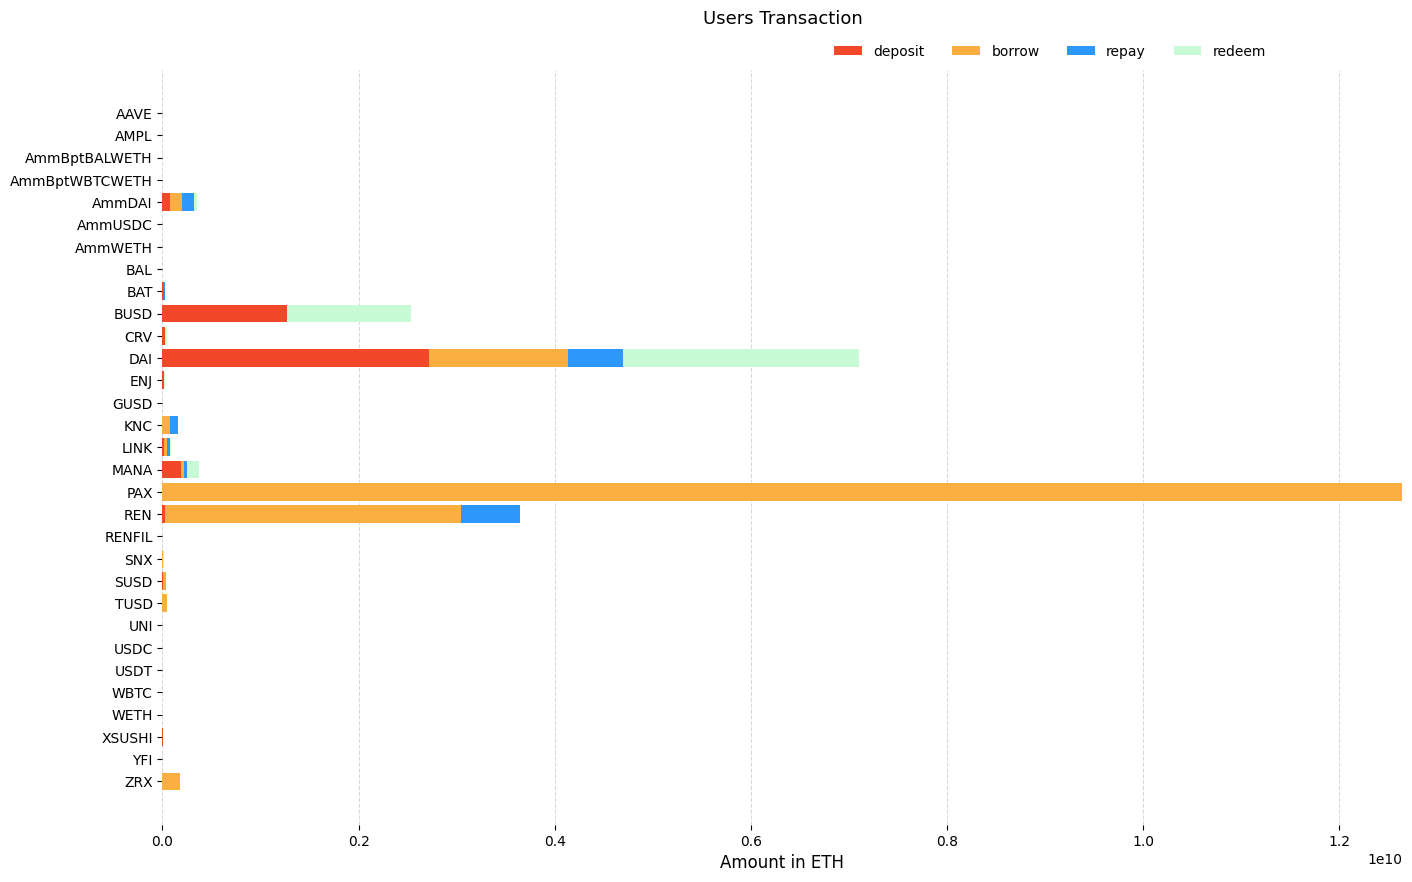

In [246]:
y_labels = sorted(list(set(np.concatenate([deposits_group.index.values,
                        borrows_group.index.values, 
                        repays_group.index.values, 
                        redeems_group.index.values]))))

x_deposits = [deposits_group.loc[idx, 'deposit_amountInEth'] if idx in deposits_group.index.values else 0 
              for idx in x_axis]

x_borrows = [borrows_group.loc[idx, 'borrow_amountInEth'] if idx in borrows_group.index.values else 0 
              for idx in x_axis]

x_repays = [repays_group.loc[idx, 'repay_amountInEth'] if idx in repays_group.index.values else 0 
              for idx in x_axis]

x_redeems = [redeems_group.loc[idx, 'redeem_amountInEth'] if idx in redeems_group.index.values else 0 
              for idx in x_axis]

spectral_palette = {
    'red': '#F04829',
    'yellow': '#FAAF40',
    'blue': '#2D97FC',
    'green': '#C8FAD5'
}

height = 0.8

fig = plt.figure(figsize=(16, 10), dpi=100)
ax = fig.add_subplot(111)

labels = ['deposit', 'borrow', 'repay', 'redeem']
x_values = [x_deposits, x_borrows, x_repays, x_redeems]
colors = [spectral_palette['red'], spectral_palette['yellow'], 
          spectral_palette['blue'], spectral_palette['green']]

left = len(y_labels) * [0]
for x_value, label, color in zip(x_values, labels, colors):
    ax.barh(y_labels, x_value, label=label, color=color, height=height, left=left)
    left = np.add(left, x_value)

ax.invert_yaxis()
ax.legend(labels, bbox_to_anchor=([0.9, 1.05, 0, 0]), ncol=4, frameon=False)
ax.set_title('Users Transaction', y = 1.05, fontweight = 'light', fontsize = 13)
ax.set_xlabel('Amount in ETH', ha='center', fontsize = 12)

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
#plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)



In [84]:
# filtering rewards cols are zero and all amount cols are NaN but redeem amount
noredeem_amount_cols = amount_cols[:-1]
withRedeem_nanAmount_zeroRewards = transactions_df[(transactions_df[noredeem_amount_cols].isna().all(1)) & 
                          ((transactions_df[rewards_cols] == 0).all(1))]

withRedeem_nanAmount_zeroRewards

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
176,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LINK,16150.746872
177,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,XSUSHI,919913.450415
178,0x002190e2f72c750bdca1784c3b1344fc2f785992,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,USDT,0.000072


In [85]:
transactions_df.drop(withRedeem_nanAmount_zeroRewards.index, inplace=True)

In [94]:
# filtering rewards cols are zero and all amount cols are NaN but repay amount
norepay_amount_cols = amount_cols[:2] + [amount_cols[-1]]
withRepay_nanAmount_zeroRewards = transactions_df[(transactions_df[norepay_amount_cols].isna().all(1)) & 
                          ((transactions_df[rewards_cols] == 0).all(1))]

withRepay_nanAmount_zeroRewards

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
46,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,DAI,3.129738e+06,NaN,NaN
150,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,NaN,NaN,WETH,3.600097e+01,NaN,NaN
164,0x0000000484f2217f1a64eb6d24b5cee446faeae5,0.0,0.0,0.0,NaN,NaN,NaN,NaN,WETH,3.000029e+02,NaN,NaN
166,0x004c7f45a2cee4336a07480fc8fa78c101c10409,0.0,0.0,0.0,NaN,NaN,NaN,NaN,AmmWETH,8.600000e+01,NaN,NaN


In [95]:
transactions_df[transactions_df.user_id == '0x000f75539c2bc3941e4a29acb1d9a8254eff427f']

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
49,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,AAVE,1.231684e+03,NaN,NaN,NaN,NaN,AAVE,1.231684e+03
50,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,CRV,7.098747e+06,NaN,NaN,NaN,NaN,NaN,NaN
51,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,DAI,7.762912e+07,NaN,NaN,NaN,NaN,DAI,7.764829e+07
52,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,YFI,2.629342e-01,NaN,NaN,NaN,NaN,YFI,2.634206e-01
148,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,USDC,0.000064,USDC,0.000064,NaN,NaN
149,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,USDT,0.000064,USDT,0.000064,NaN,NaN
150,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,NaN,NaN,NaN,NaN,WETH,36.000974,NaN,NaN


In [38]:
no_transactions

['0x000000c3cfd83e7f9d856bed82231e8a00a1b07f',
 '0x003bc8351ba2a942784b57464a00497ee6734a08',
 '0x003626ab1a6ae0f0c4f5967a7f4f5eea3aa225ac',
 '0x000000e28faa823d5b53ff6c2922c28335840375',
 '0x001384c2cf7580dcda7101c86dfbf7eb666af025',
 '0x0038328ab1bb169cf178a6bc6e58a7af5d5b38f9',
 '0x0037daf6fb154db55110ced85cb4ba9e1204ca17',
 '0x0028e0ba2ae3d8d52ea00ec24f995033af26ce28',
 '0x002e7f273b46e0abad44d381aa74795df5780089',
 '0x00212d13dd8acd1fb59471a6f819d77f768f48f4',
 '0x000a0b24b1476f647a2a2fa4474f9ed32c685a8e',
 '0x0000000000d41c96294ccdac8612bdfe29c641af',
 '0x0038fcee9272507cdbbb66771c8a128272c50c71',
 '0x005280119e7070fd1999703ec606c5e97b146e84',
 '0x002c7d9664832d6e9ecb49eee284cd4470ae8114',
 '0x0000fee6275dab194ab538a01dd8b18b02b20000']